# References and variables

In [115]:
#import warnings
#warnings.filterwarnings('ignore')

import sys
sys.path.append('../fastai/old/') #fastai version 0.7

from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt

from torchsummary import summary
from torchvision.models import *

In [2]:
PATH = '/home/Deep_Learner/work/datasets/human-protein-atlas-image-classification/'
TRAIN = '/home/Deep_Learner/work/datasets/human-protein-atlas-image-classification/stage1_data/train_pngs_512'
#TRAIN = '/home/Deep_Learner/shared/Human_Protein_Atlas/train_rgby'
TEST = '/home/Deep_Learner/work/datasets/human-protein-atlas-image-classification/stage1_data/test_pngs_512'
#TEST = '/home/Deep_Learner/shared/Human_Protein_Atlas/test_rgby'
LABELS = '/home/Deep_Learner/work/datasets/human-protein-atlas-image-classification/stage1_data/train.csv'
SAMPLE = '/home/Deep_Learner/work/datasets/human-protein-atlas-image-classification/stage1_data/sample_submission.csv'

name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

nw = 8   #number of workers for data loader
sz = 512 #image size
bs = 16 #batch size
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True

# Data

In [3]:
train_names = list({f[:36] for f in os.listdir(TRAIN)})
test_names = list({f[:36] for f in os.listdir(TEST)})
tr_n, val_n = train_test_split(train_names, test_size=0.1, random_state=42)

def open_rgby(path,id): #a function that reads RGBY image
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)

class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_rgby(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes
    
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    
    #mean and std in of each channel in the train set
    #stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814]) #512 pngs without augmentation
    stats = A([0.08689, 0.06003, 0.06515, 0.08908], [0.14105, 0.10544, 0.15164, 0.14178]) #512 pngs
    #stats = A([0.08677, 0.05965, 0.06497, 0.0889 ], [0.14219, 0.10513, 0.1519 , 0.1411 ])  #full size pngs
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

Plot several examples of input images.

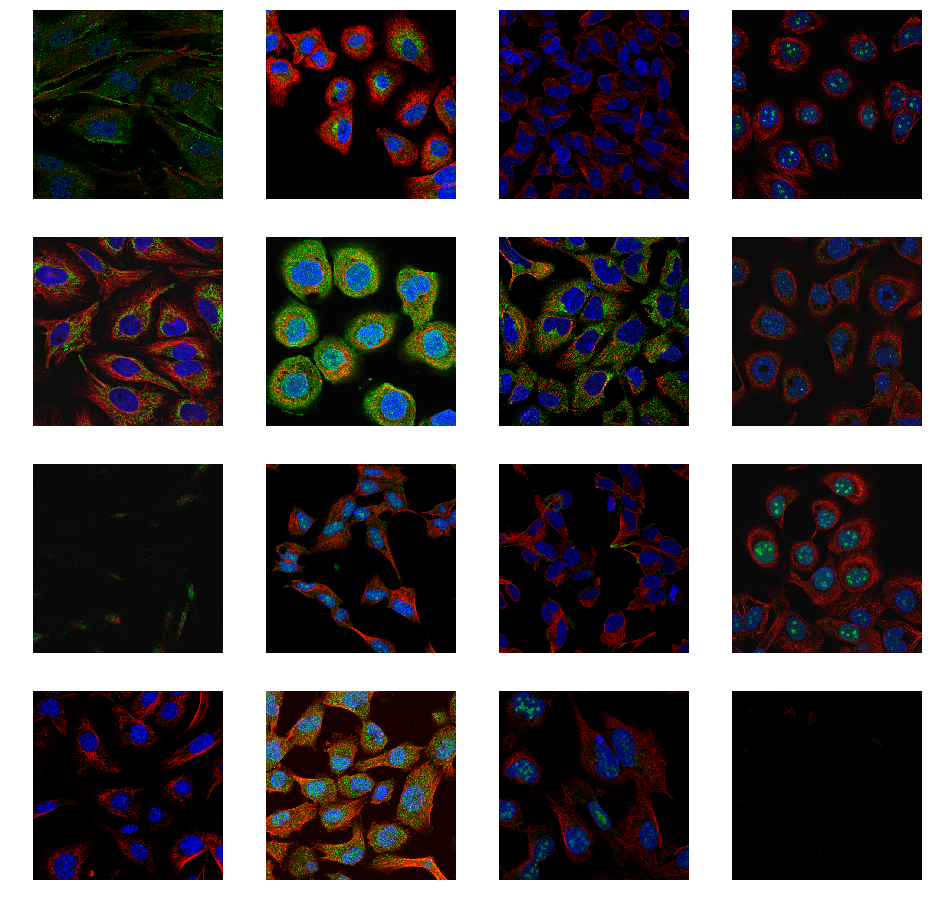

In [8]:
md = get_data(sz,bs)

x,y = next(iter(md.trn_dl))
x.shape, y.shape

def display_imgs(x):
    columns = 4
    bs = x.shape[0]
    rows = min((bs+3)//4,4)
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow((x[idx,:,:,:3]*255).astype(np.int))
    plt.show()
    
display_imgs(np.asarray(md.trn_ds.denorm(x)))

# Computing image statistics in the train set for normailzation

In [10]:
x_tot = np.zeros(4)
x2_tot = np.zeros(4)
for x,y in iter(md.trn_dl):
    tmp =  md.trn_ds.denorm(x).reshape(16,-1)
    x = md.trn_ds.denorm(x).reshape(-1,4)
    x_tot += x.mean(axis=0)
    x2_tot += (x**2).mean(axis=0)

channel_avr = x_tot/len(md.trn_dl)
channel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)
channel_avr,channel_std

(array([0.08677, 0.05965, 0.06497, 0.0889 ]),
 array([0.14219, 0.10513, 0.1519 , 0.1411 ]))

# Loss function and metrics

In [4]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()
    
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

# Custom ConvnetBuilder

In [164]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
#model = torchvision.models.inception_v3(True).to(device)
#summary(model, (3, 299, 299))
#
#ar = inception_v3(True)
#
#ar.Conv2d_1a_3x3.conv
#
#layers_test = cut_model(ar, -1)
#
#layers_test[0].conv
#
#layers_test[0].conv

In [165]:
class ConvnetBuilder_custom():
    def __init__(self, f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, 
                 custom_head=None, pretrained=True):
        self.f,self.c,self.is_multi,self.is_reg,self.xtra_cut = f,c,is_multi,is_reg,xtra_cut
        if xtra_fc is None: xtra_fc = [512]
        if ps is None: ps = [0.25]*len(xtra_fc) + [0.5]
        self.ps,self.xtra_fc = ps,xtra_fc

        if f in model_meta: cut,self.lr_cut = model_meta[f]
        else: cut,self.lr_cut = 0,0
        cut-=xtra_cut
        layers = cut_model(f(pretrained), cut)
        
        #replace first convolutional layer by 4->64 while keeping corresponding weights
        #and initializing new weights with channel 1 weights
        if f in [inception_4]:
            w = layers[0].conv.weight
            layers[0].conv = nn.Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
            layers[0].conv.weight = torch.nn.Parameter(torch.cat((w,w[:,:1,:,:]),dim=1))
                          
        if f in [inception_v3]:
            w = layers[0].Conv2d_1a_3x3.conv.weight
            layers[0].Conv2d_1a_3x3.conv = nn.Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
            layers[0].Conv2d_1a_3x3.conv.weight = torch.nn.Parameter(torch.cat((w,w[:,:1,:,:]),dim=1))
            
        if f in [resnet18, resnet34, resnet50, resnet101, resnet152]:
            w = layers[0].weight
            layers[0] = nn.Conv2d(4,64,kernel_size=(7,7),stride=(2,2),padding=(3, 3), bias=False)
            #layers[0].weight = torch.nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1)) #init with zeros
            layers[0].weight = torch.nn.Parameter(torch.cat((w,w[:,:1,:,:]),dim=1)) # init with weights of 1st channel

        #else:
            #raise ValueError('Function f for creating the model not supported!')
        
        self.nf = model_features[f] if f in model_features else (num_features(layers)*2)
        if not custom_head: layers += [AdaptiveConcatPool2d(), Flatten()]
        self.top_model = nn.Sequential(*layers)

        n_fc = len(self.xtra_fc)+1
        if not isinstance(self.ps, list): self.ps = [self.ps]*n_fc

        if custom_head: fc_layers = [custom_head]
        else: fc_layers = self.get_fc_layers()
        self.n_fc = len(fc_layers)
        self.fc_model = to_gpu(nn.Sequential(*fc_layers))
        if not custom_head: apply_init(self.fc_model, kaiming_normal)
        self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

    @property
    def name(self): return f'{self.f.__name__}_{self.xtra_cut}'

    def create_fc_layer(self, ni, nf, p, actn=None):
        res=[nn.BatchNorm1d(num_features=ni)]
        if p: res.append(nn.Dropout(p=p))
        res.append(nn.Linear(in_features=ni, out_features=nf))
        if actn: res.append(actn)
        return res

    def get_fc_layers(self):
        res=[]
        ni=self.nf
        for i,nf in enumerate(self.xtra_fc):
            res += self.create_fc_layer(ni, nf, p=self.ps[i], actn=nn.ReLU())
            ni=nf
        final_actn = nn.Sigmoid() if self.is_multi else nn.LogSoftmax()
        if self.is_reg: final_actn = None
        res += self.create_fc_layer(ni, self.c, p=self.ps[-1], actn=final_actn)
        return res

    def get_layer_groups(self, do_fc=False):
        if do_fc:
            return [self.fc_model]
        idxs = [self.lr_cut]
        c = children(self.top_model)
        if len(c)==3: c = children(c[0])+c[1:]
        lgs = list(split_by_idxs(c,idxs))
        return lgs+[self.fc_model]
    
class ConvLearner(Learner):
    def __init__(self, data, models, precompute=False, **kwargs):
        self.precompute = False
        super().__init__(data, models, **kwargs)
        if hasattr(data, 'is_multi') and not data.is_reg and self.metrics is None:
            self.metrics = [accuracy_thresh(0.5)] if self.data.is_multi else [accuracy]
        if precompute: self.save_fc1()
        self.freeze()
        self.precompute = precompute

    def _get_crit(self, data):
        if not hasattr(data, 'is_multi'): return super()._get_crit(data)

        return F.l1_loss if data.is_reg else F.binary_cross_entropy if data.is_multi else F.nll_loss

    @classmethod
    def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                   pretrained=True, **kwargs):
        models = ConvnetBuilder_custom(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=pretrained)
        return cls(data, models, precompute, **kwargs)

    @classmethod
    def lsuv_learner(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                  needed_std=1.0, std_tol=0.1, max_attempts=10, do_orthonorm=False, **kwargs):
        models = ConvnetBuilder(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=False)
        convlearn=cls(data, models, precompute, **kwargs)
        convlearn.lsuv_init()
        return convlearn
    
    @property
    def model(self): return self.models.fc_model if self.precompute else self.models.model
    
    def half(self):
        if self.fp16: return
        self.fp16 = True
        if type(self.model) != FP16: self.models.model = FP16(self.model)
        if not isinstance(self.models.fc_model, FP16): self.models.fc_model = FP16(self.models.fc_model)
    def float(self):
        if not self.fp16: return
        self.fp16 = False
        if type(self.models.model) == FP16: self.models.model = self.model.module.float()
        if type(self.models.fc_model) == FP16: self.models.fc_model = self.models.fc_model.module.float()

    @property
    def data(self): return self.fc_data if self.precompute else self.data_

    def create_empty_bcolz(self, n, name):
        return bcolz.carray(np.zeros((0,n), np.float32), chunklen=1, mode='w', rootdir=name)

    def set_data(self, data, precompute=False):
        super().set_data(data)
        if precompute:
            self.unfreeze()
            self.save_fc1()
            self.freeze()
            self.precompute = True
        else:
            self.freeze()

    def get_layer_groups(self):
        return self.models.get_layer_groups(self.precompute)

    def summary(self):
        precompute = self.precompute
        self.precompute = False
        res = super().summary()
        self.precompute = precompute
        return res

    def get_activations(self, force=False):
        tmpl = f'_{self.models.name}_{self.data.sz}.bc'
        # TODO: Somehow check that directory names haven't changed (e.g. added test set)
        names = [os.path.join(self.tmp_path, p+tmpl) for p in ('x_act', 'x_act_val', 'x_act_test')]
        if os.path.exists(names[0]) and not force:
            self.activations = [bcolz.open(p) for p in names]
        else:
            self.activations = [self.create_empty_bcolz(self.models.nf,n) for n in names]

    def save_fc1(self):
        self.get_activations()
        act, val_act, test_act = self.activations
        m=self.models.top_model
        if len(self.activations[0])!=len(self.data.trn_ds):
            predict_to_bcolz(m, self.data.fix_dl, act)
        if len(self.activations[1])!=len(self.data.val_ds):
            predict_to_bcolz(m, self.data.val_dl, val_act)
        if self.data.test_dl and (len(self.activations[2])!=len(self.data.test_ds)):
            if self.data.test_dl: predict_to_bcolz(m, self.data.test_dl, test_act)

        self.fc_data = ImageClassifierData.from_arrays(self.data.path,
                (act, self.data.trn_y), (val_act, self.data.val_y), self.data.bs, classes=self.data.classes,
                test = test_act if self.data.test_dl else None, num_workers=8)

    def freeze(self):
        self.freeze_to(-1)

    def unfreeze(self):
        self.freeze_to(0)
        self.precompute = False

    def predict_array(self, arr):
        precompute = self.precompute
        self.precompute = False
        pred = super().predict_array(arr)
        self.precompute = precompute
        return pred

# Training

In [166]:
#arch = inception_4 #specify target architecture
arch = inception_v3

In [167]:
md = get_data(sz,bs)
learner = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
learner.metrics = [acc]

In [168]:
learner.summary

<bound method ConvLearner.summary of Sequential(
  (0): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): BasicConv2d(
      (conv): Conv2d(80, 192, kernel_size=(3, 3), s

In [9]:
import warnings
warnings.filterwarnings('ignore')

 64%|██████▍   | 2229/3495 [2:29:04<1:24:39,  4.01s/it, loss=6.27]

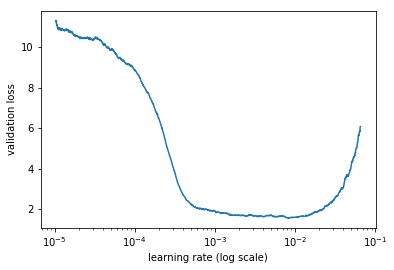

In [35]:
learner.lr_find()
learner.sched.plot()

First, I train only the head of the model while keeping the rest frozen. It allows to avoid corruption of the pretrained weights at the initial stage of training due to random initialization of the head layers. So the power of transfer learning is fully utilized when the training is continued.

In [ ]:
lr = 3e-4
learner.fit(lr,1)

 79%|███████▉  | 3672/4660 [4:05:30<1:06:03,  4.01s/it, loss=1.41]

In [ ]:
learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [ ]:
learner.fit(lrs/4,4,cycle_len=2,use_clr=(10,20))

In [ ]:
learner.fit(lrs/4,2,cycle_len=4,use_clr=(10,20))

In [ ]:
learner.sched.plot_lr()

In [ ]:
learner.fit(lrs/16,1,cycle_len=8,use_clr=(5,20))

In [101]:
name = 'inception_4_sz512_bs16_fastaiV07'

In [ ]:
learner.save(name)

In [102]:
learner.load(name)

RuntimeError: Error(s) in loading state_dict for Sequential:
	Missing key(s) in state_dict: "0.weight", "1.weight", "1.bias", "1.running_mean", "1.running_var", "4.0.conv1.weight", "4.0.bn1.weight", "4.0.bn1.bias", "4.0.bn1.running_mean", "4.0.bn1.running_var", "4.0.conv2.weight", "4.0.bn2.weight", "4.0.bn2.bias", "4.0.bn2.running_mean", "4.0.bn2.running_var", "4.1.conv1.weight", "4.1.bn1.weight", "4.1.bn1.bias", "4.1.bn1.running_mean", "4.1.bn1.running_var", "4.1.conv2.weight", "4.1.bn2.weight", "4.1.bn2.bias", "4.1.bn2.running_mean", "4.1.bn2.running_var", "4.2.conv1.weight", "4.2.bn1.weight", "4.2.bn1.bias", "4.2.bn1.running_mean", "4.2.bn1.running_var", "4.2.conv2.weight", "4.2.bn2.weight", "4.2.bn2.bias", "4.2.bn2.running_mean", "4.2.bn2.running_var", "5.0.conv1.weight", "5.0.bn1.weight", "5.0.bn1.bias", "5.0.bn1.running_mean", "5.0.bn1.running_var", "5.0.conv2.weight", "5.0.bn2.weight", "5.0.bn2.bias", "5.0.bn2.running_mean", "5.0.bn2.running_var", "5.0.downsample.0.weight", "5.0.downsample.1.weight", "5.0.downsample.1.bias", "5.0.downsample.1.running_mean", "5.0.downsample.1.running_var", "5.1.conv1.weight", "5.1.bn1.weight", "5.1.bn1.bias", "5.1.bn1.running_mean", "5.1.bn1.running_var", "5.1.conv2.weight", "5.1.bn2.weight", "5.1.bn2.bias", "5.1.bn2.running_mean", "5.1.bn2.running_var", "5.2.conv1.weight", "5.2.bn1.weight", "5.2.bn1.bias", "5.2.bn1.running_mean", "5.2.bn1.running_var", "5.2.conv2.weight", "5.2.bn2.weight", "5.2.bn2.bias", "5.2.bn2.running_mean", "5.2.bn2.running_var", "5.3.conv1.weight", "5.3.bn1.weight", "5.3.bn1.bias", "5.3.bn1.running_mean", "5.3.bn1.running_var", "5.3.conv2.weight", "5.3.bn2.weight", "5.3.bn2.bias", "5.3.bn2.running_mean", "5.3.bn2.running_var", "6.0.conv1.weight", "6.0.bn1.weight", "6.0.bn1.bias", "6.0.bn1.running_mean", "6.0.bn1.running_var", "6.0.conv2.weight", "6.0.bn2.weight", "6.0.bn2.bias", "6.0.bn2.running_mean", "6.0.bn2.running_var", "6.0.downsample.0.weight", "6.0.downsample.1.weight", "6.0.downsample.1.bias", "6.0.downsample.1.running_mean", "6.0.downsample.1.running_var", "6.1.conv1.weight", "6.1.bn1.weight", "6.1.bn1.bias", "6.1.bn1.running_mean", "6.1.bn1.running_var", "6.1.conv2.weight", "6.1.bn2.weight", "6.1.bn2.bias", "6.1.bn2.running_mean", "6.1.bn2.running_var", "6.2.conv1.weight", "6.2.bn1.weight", "6.2.bn1.bias", "6.2.bn1.running_mean", "6.2.bn1.running_var", "6.2.conv2.weight", "6.2.bn2.weight", "6.2.bn2.bias", "6.2.bn2.running_mean", "6.2.bn2.running_var", "6.3.conv1.weight", "6.3.bn1.weight", "6.3.bn1.bias", "6.3.bn1.running_mean", "6.3.bn1.running_var", "6.3.conv2.weight", "6.3.bn2.weight", "6.3.bn2.bias", "6.3.bn2.running_mean", "6.3.bn2.running_var", "6.4.conv1.weight", "6.4.bn1.weight", "6.4.bn1.bias", "6.4.bn1.running_mean", "6.4.bn1.running_var", "6.4.conv2.weight", "6.4.bn2.weight", "6.4.bn2.bias", "6.4.bn2.running_mean", "6.4.bn2.running_var", "6.5.conv1.weight", "6.5.bn1.weight", "6.5.bn1.bias", "6.5.bn1.running_mean", "6.5.bn1.running_var", "6.5.conv2.weight", "6.5.bn2.weight", "6.5.bn2.bias", "6.5.bn2.running_mean", "6.5.bn2.running_var", "7.0.conv1.weight", "7.0.bn1.weight", "7.0.bn1.bias", "7.0.bn1.running_mean", "7.0.bn1.running_var", "7.0.conv2.weight", "7.0.bn2.weight", "7.0.bn2.bias", "7.0.bn2.running_mean", "7.0.bn2.running_var", "7.0.downsample.0.weight", "7.0.downsample.1.weight", "7.0.downsample.1.bias", "7.0.downsample.1.running_mean", "7.0.downsample.1.running_var", "7.1.conv1.weight", "7.1.bn1.weight", "7.1.bn1.bias", "7.1.bn1.running_mean", "7.1.bn1.running_var", "7.1.conv2.weight", "7.1.bn2.weight", "7.1.bn2.bias", "7.1.bn2.running_mean", "7.1.bn2.running_var", "7.2.conv1.weight", "7.2.bn1.weight", "7.2.bn1.bias", "7.2.bn1.running_mean", "7.2.bn1.running_var", "7.2.conv2.weight", "7.2.bn2.weight", "7.2.bn2.bias", "7.2.bn2.running_mean", "7.2.bn2.running_var", "10.weight", "10.bias", "10.running_mean", "10.running_var", "12.weight", "12.bias", "14.weight", "14.bias", "14.running_mean", "14.running_var", "16.weight", "16.bias". 
	Unexpected key(s) in state_dict: "17.block0.conv.weight", "17.block0.bn.weight", "17.block0.bn.bias", "17.block0.bn.running_mean", "17.block0.bn.running_var", "17.block0.bn.num_batches_tracked", "17.block1.0.conv.weight", "17.block1.0.bn.weight", "17.block1.0.bn.bias", "17.block1.0.bn.running_mean", "17.block1.0.bn.running_var", "17.block1.0.bn.num_batches_tracked", "17.block1.1.conv.weight", "17.block1.1.bn.weight", "17.block1.1.bn.bias", "17.block1.1.bn.running_mean", "17.block1.1.bn.running_var", "17.block1.1.bn.num_batches_tracked", "17.block1.2.conv.weight", "17.block1.2.bn.weight", "17.block1.2.bn.bias", "17.block1.2.bn.running_mean", "17.block1.2.bn.running_var", "17.block1.2.bn.num_batches_tracked", "17.block2.0.conv.weight", "17.block2.0.bn.weight", "17.block2.0.bn.bias", "17.block2.0.bn.running_mean", "17.block2.0.bn.running_var", "17.block2.0.bn.num_batches_tracked", "17.block2.1.conv.weight", "17.block2.1.bn.weight", "17.block2.1.bn.bias", "17.block2.1.bn.running_mean", "17.block2.1.bn.running_var", "17.block2.1.bn.num_batches_tracked", "17.block2.2.conv.weight", "17.block2.2.bn.weight", "17.block2.2.bn.bias", "17.block2.2.bn.running_mean", "17.block2.2.bn.running_var", "17.block2.2.bn.num_batches_tracked", "17.block2.3.conv.weight", "17.block2.3.bn.weight", "17.block2.3.bn.bias", "17.block2.3.bn.running_mean", "17.block2.3.bn.running_var", "17.block2.3.bn.num_batches_tracked", "17.block2.4.conv.weight", "17.block2.4.bn.weight", "17.block2.4.bn.bias", "17.block2.4.bn.running_mean", "17.block2.4.bn.running_var", "17.block2.4.bn.num_batches_tracked", "17.block3.1.conv.weight", "17.block3.1.bn.weight", "17.block3.1.bn.bias", "17.block3.1.bn.running_mean", "17.block3.1.bn.running_var", "17.block3.1.bn.num_batches_tracked", "18.block0.0.conv.weight", "18.block0.0.bn.weight", "18.block0.0.bn.bias", "18.block0.0.bn.running_mean", "18.block0.0.bn.running_var", "18.block0.0.bn.num_batches_tracked", "18.block0.1.conv.weight", "18.block0.1.bn.weight", "18.block0.1.bn.bias", "18.block0.1.bn.running_mean", "18.block0.1.bn.running_var", "18.block0.1.bn.num_batches_tracked", "18.block1.0.conv.weight", "18.block1.0.bn.weight", "18.block1.0.bn.bias", "18.block1.0.bn.running_mean", "18.block1.0.bn.running_var", "18.block1.0.bn.num_batches_tracked", "18.block1.1.conv.weight", "18.block1.1.bn.weight", "18.block1.1.bn.bias", "18.block1.1.bn.running_mean", "18.block1.1.bn.running_var", "18.block1.1.bn.num_batches_tracked", "18.block1.2.conv.weight", "18.block1.2.bn.weight", "18.block1.2.bn.bias", "18.block1.2.bn.running_mean", "18.block1.2.bn.running_var", "18.block1.2.bn.num_batches_tracked", "18.block1.3.conv.weight", "18.block1.3.bn.weight", "18.block1.3.bn.bias", "18.block1.3.bn.running_mean", "18.block1.3.bn.running_var", "18.block1.3.bn.num_batches_tracked", "19.block0.conv.weight", "19.block0.bn.weight", "19.block0.bn.bias", "19.block0.bn.running_mean", "19.block0.bn.running_var", "19.block0.bn.num_batches_tracked", "19.block1_0.conv.weight", "19.block1_0.bn.weight", "19.block1_0.bn.bias", "19.block1_0.bn.running_mean", "19.block1_0.bn.running_var", "19.block1_0.bn.num_batches_tracked", "19.block1_1a.conv.weight", "19.block1_1a.bn.weight", "19.block1_1a.bn.bias", "19.block1_1a.bn.running_mean", "19.block1_1a.bn.running_var", "19.block1_1a.bn.num_batches_tracked", "19.block1_1b.conv.weight", "19.block1_1b.bn.weight", "19.block1_1b.bn.bias", "19.block1_1b.bn.running_mean", "19.block1_1b.bn.running_var", "19.block1_1b.bn.num_batches_tracked", "19.block2_0.conv.weight", "19.block2_0.bn.weight", "19.block2_0.bn.bias", "19.block2_0.bn.running_mean", "19.block2_0.bn.running_var", "19.block2_0.bn.num_batches_tracked", "19.block2_1.conv.weight", "19.block2_1.bn.weight", "19.block2_1.bn.bias", "19.block2_1.bn.running_mean", "19.block2_1.bn.running_var", "19.block2_1.bn.num_batches_tracked", "19.block2_2.conv.weight", "19.block2_2.bn.weight", "19.block2_2.bn.bias", "19.block2_2.bn.running_mean", "19.block2_2.bn.running_var", "19.block2_2.bn.num_batches_tracked", "19.block2_3a.conv.weight", "19.block2_3a.bn.weight", "19.block2_3a.bn.bias", "19.block2_3a.bn.running_mean", "19.block2_3a.bn.running_var", "19.block2_3a.bn.num_batches_tracked", "19.block2_3b.conv.weight", "19.block2_3b.bn.weight", "19.block2_3b.bn.bias", "19.block2_3b.bn.running_mean", "19.block2_3b.bn.running_var", "19.block2_3b.bn.num_batches_tracked", "19.block3.1.conv.weight", "19.block3.1.bn.weight", "19.block3.1.bn.bias", "19.block3.1.bn.running_mean", "19.block3.1.bn.running_var", "19.block3.1.bn.num_batches_tracked", "20.block0.conv.weight", "20.block0.bn.weight", "20.block0.bn.bias", "20.block0.bn.running_mean", "20.block0.bn.running_var", "20.block0.bn.num_batches_tracked", "20.block1_0.conv.weight", "20.block1_0.bn.weight", "20.block1_0.bn.bias", "20.block1_0.bn.running_mean", "20.block1_0.bn.running_var", "20.block1_0.bn.num_batches_tracked", "20.block1_1a.conv.weight", "20.block1_1a.bn.weight", "20.block1_1a.bn.bias", "20.block1_1a.bn.running_mean", "20.block1_1a.bn.running_var", "20.block1_1a.bn.num_batches_tracked", "20.block1_1b.conv.weight", "20.block1_1b.bn.weight", "20.block1_1b.bn.bias", "20.block1_1b.bn.running_mean", "20.block1_1b.bn.running_var", "20.block1_1b.bn.num_batches_tracked", "20.block2_0.conv.weight", "20.block2_0.bn.weight", "20.block2_0.bn.bias", "20.block2_0.bn.running_mean", "20.block2_0.bn.running_var", "20.block2_0.bn.num_batches_tracked", "20.block2_1.conv.weight", "20.block2_1.bn.weight", "20.block2_1.bn.bias", "20.block2_1.bn.running_mean", "20.block2_1.bn.running_var", "20.block2_1.bn.num_batches_tracked", "20.block2_2.conv.weight", "20.block2_2.bn.weight", "20.block2_2.bn.bias", "20.block2_2.bn.running_mean", "20.block2_2.bn.running_var", "20.block2_2.bn.num_batches_tracked", "20.block2_3a.conv.weight", "20.block2_3a.bn.weight", "20.block2_3a.bn.bias", "20.block2_3a.bn.running_mean", "20.block2_3a.bn.running_var", "20.block2_3a.bn.num_batches_tracked", "20.block2_3b.conv.weight", "20.block2_3b.bn.weight", "20.block2_3b.bn.bias", "20.block2_3b.bn.running_mean", "20.block2_3b.bn.running_var", "20.block2_3b.bn.num_batches_tracked", "20.block3.1.conv.weight", "20.block3.1.bn.weight", "20.block3.1.bn.bias", "20.block3.1.bn.running_mean", "20.block3.1.bn.running_var", "20.block3.1.bn.num_batches_tracked", "21.block0.conv.weight", "21.block0.bn.weight", "21.block0.bn.bias", "21.block0.bn.running_mean", "21.block0.bn.running_var", "21.block0.bn.num_batches_tracked", "21.block1_0.conv.weight", "21.block1_0.bn.weight", "21.block1_0.bn.bias", "21.block1_0.bn.running_mean", "21.block1_0.bn.running_var", "21.block1_0.bn.num_batches_tracked", "21.block1_1a.conv.weight", "21.block1_1a.bn.weight", "21.block1_1a.bn.bias", "21.block1_1a.bn.running_mean", "21.block1_1a.bn.running_var", "21.block1_1a.bn.num_batches_tracked", "21.block1_1b.conv.weight", "21.block1_1b.bn.weight", "21.block1_1b.bn.bias", "21.block1_1b.bn.running_mean", "21.block1_1b.bn.running_var", "21.block1_1b.bn.num_batches_tracked", "21.block2_0.conv.weight", "21.block2_0.bn.weight", "21.block2_0.bn.bias", "21.block2_0.bn.running_mean", "21.block2_0.bn.running_var", "21.block2_0.bn.num_batches_tracked", "21.block2_1.conv.weight", "21.block2_1.bn.weight", "21.block2_1.bn.bias", "21.block2_1.bn.running_mean", "21.block2_1.bn.running_var", "21.block2_1.bn.num_batches_tracked", "21.block2_2.conv.weight", "21.block2_2.bn.weight", "21.block2_2.bn.bias", "21.block2_2.bn.running_mean", "21.block2_2.bn.running_var", "21.block2_2.bn.num_batches_tracked", "21.block2_3a.conv.weight", "21.block2_3a.bn.weight", "21.block2_3a.bn.bias", "21.block2_3a.bn.running_mean", "21.block2_3a.bn.running_var", "21.block2_3a.bn.num_batches_tracked", "21.block2_3b.conv.weight", "21.block2_3b.bn.weight", "21.block2_3b.bn.bias", "21.block2_3b.bn.running_mean", "21.block2_3b.bn.running_var", "21.block2_3b.bn.num_batches_tracked", "21.block3.1.conv.weight", "21.block3.1.bn.weight", "21.block3.1.bn.bias", "21.block3.1.bn.running_mean", "21.block3.1.bn.running_var", "21.block3.1.bn.num_batches_tracked", "24.weight", "24.bias", "24.running_mean", "24.running_var", "24.num_batches_tracked", "26.weight", "26.bias", "28.weight", "28.bias", "28.running_mean", "28.running_var", "28.num_batches_tracked", "30.weight", "30.bias", "0.conv.weight", "0.bn.weight", "0.bn.bias", "0.bn.running_mean", "0.bn.running_var", "0.bn.num_batches_tracked", "1.conv.weight", "1.bn.weight", "1.bn.bias", "1.bn.running_mean", "1.bn.running_var", "1.bn.num_batches_tracked", "2.conv.weight", "2.bn.weight", "2.bn.bias", "2.bn.running_mean", "2.bn.running_var", "2.bn.num_batches_tracked", "3.conv.conv.weight", "3.conv.bn.weight", "3.conv.bn.bias", "3.conv.bn.running_mean", "3.conv.bn.running_var", "3.conv.bn.num_batches_tracked", "4.block0.0.conv.weight", "4.block0.0.bn.weight", "4.block0.0.bn.bias", "4.block0.0.bn.running_mean", "4.block0.0.bn.running_var", "4.block0.0.bn.num_batches_tracked", "4.block0.1.conv.weight", "4.block0.1.bn.weight", "4.block0.1.bn.bias", "4.block0.1.bn.running_mean", "4.block0.1.bn.running_var", "4.block0.1.bn.num_batches_tracked", "4.block1.0.conv.weight", "4.block1.0.bn.weight", "4.block1.0.bn.bias", "4.block1.0.bn.running_mean", "4.block1.0.bn.running_var", "4.block1.0.bn.num_batches_tracked", "4.block1.1.conv.weight", "4.block1.1.bn.weight", "4.block1.1.bn.bias", "4.block1.1.bn.running_mean", "4.block1.1.bn.running_var", "4.block1.1.bn.num_batches_tracked", "4.block1.2.conv.weight", "4.block1.2.bn.weight", "4.block1.2.bn.bias", "4.block1.2.bn.running_mean", "4.block1.2.bn.running_var", "4.block1.2.bn.num_batches_tracked", "4.block1.3.conv.weight", "4.block1.3.bn.weight", "4.block1.3.bn.bias", "4.block1.3.bn.running_mean", "4.block1.3.bn.running_var", "4.block1.3.bn.num_batches_tracked", "5.conv.conv.weight", "5.conv.bn.weight", "5.conv.bn.bias", "5.conv.bn.running_mean", "5.conv.bn.running_var", "5.conv.bn.num_batches_tracked", "6.block0.conv.weight", "6.block0.bn.weight", "6.block0.bn.bias", "6.block0.bn.running_mean", "6.block0.bn.running_var", "6.block0.bn.num_batches_tracked", "6.block1.0.conv.weight", "6.block1.0.bn.weight", "6.block1.0.bn.bias", "6.block1.0.bn.running_mean", "6.block1.0.bn.running_var", "6.block1.0.bn.num_batches_tracked", "6.block1.1.conv.weight", "6.block1.1.bn.weight", "6.block1.1.bn.bias", "6.block1.1.bn.running_mean", "6.block1.1.bn.running_var", "6.block1.1.bn.num_batches_tracked", "6.block2.0.conv.weight", "6.block2.0.bn.weight", "6.block2.0.bn.bias", "6.block2.0.bn.running_mean", "6.block2.0.bn.running_var", "6.block2.0.bn.num_batches_tracked", "6.block2.1.conv.weight", "6.block2.1.bn.weight", "6.block2.1.bn.bias", "6.block2.1.bn.running_mean", "6.block2.1.bn.running_var", "6.block2.1.bn.num_batches_tracked", "6.block2.2.conv.weight", "6.block2.2.bn.weight", "6.block2.2.bn.bias", "6.block2.2.bn.running_mean", "6.block2.2.bn.running_var", "6.block2.2.bn.num_batches_tracked", "6.block3.1.conv.weight", "6.block3.1.bn.weight", "6.block3.1.bn.bias", "6.block3.1.bn.running_mean", "6.block3.1.bn.running_var", "6.block3.1.bn.num_batches_tracked", "7.block0.conv.weight", "7.block0.bn.weight", "7.block0.bn.bias", "7.block0.bn.running_mean", "7.block0.bn.running_var", "7.block0.bn.num_batches_tracked", "7.block1.0.conv.weight", "7.block1.0.bn.weight", "7.block1.0.bn.bias", "7.block1.0.bn.running_mean", "7.block1.0.bn.running_var", "7.block1.0.bn.num_batches_tracked", "7.block1.1.conv.weight", "7.block1.1.bn.weight", "7.block1.1.bn.bias", "7.block1.1.bn.running_mean", "7.block1.1.bn.running_var", "7.block1.1.bn.num_batches_tracked", "7.block2.0.conv.weight", "7.block2.0.bn.weight", "7.block2.0.bn.bias", "7.block2.0.bn.running_mean", "7.block2.0.bn.running_var", "7.block2.0.bn.num_batches_tracked", "7.block2.1.conv.weight", "7.block2.1.bn.weight", "7.block2.1.bn.bias", "7.block2.1.bn.running_mean", "7.block2.1.bn.running_var", "7.block2.1.bn.num_batches_tracked", "7.block2.2.conv.weight", "7.block2.2.bn.weight", "7.block2.2.bn.bias", "7.block2.2.bn.running_mean", "7.block2.2.bn.running_var", "7.block2.2.bn.num_batches_tracked", "7.block3.1.conv.weight", "7.block3.1.bn.weight", "7.block3.1.bn.bias", "7.block3.1.bn.running_mean", "7.block3.1.bn.running_var", "7.block3.1.bn.num_batches_tracked", "8.block0.conv.weight", "8.block0.bn.weight", "8.block0.bn.bias", "8.block0.bn.running_mean", "8.block0.bn.running_var", "8.block0.bn.num_batches_tracked", "8.block1.0.conv.weight", "8.block1.0.bn.weight", "8.block1.0.bn.bias", "8.block1.0.bn.running_mean", "8.block1.0.bn.running_var", "8.block1.0.bn.num_batches_tracked", "8.block1.1.conv.weight", "8.block1.1.bn.weight", "8.block1.1.bn.bias", "8.block1.1.bn.running_mean", "8.block1.1.bn.running_var", "8.block1.1.bn.num_batches_tracked", "8.block2.0.conv.weight", "8.block2.0.bn.weight", "8.block2.0.bn.bias", "8.block2.0.bn.running_mean", "8.block2.0.bn.running_var", "8.block2.0.bn.num_batches_tracked", "8.block2.1.conv.weight", "8.block2.1.bn.weight", "8.block2.1.bn.bias", "8.block2.1.bn.running_mean", "8.block2.1.bn.running_var", "8.block2.1.bn.num_batches_tracked", "8.block2.2.conv.weight", "8.block2.2.bn.weight", "8.block2.2.bn.bias", "8.block2.2.bn.running_mean", "8.block2.2.bn.running_var", "8.block2.2.bn.num_batches_tracked", "8.block3.1.conv.weight", "8.block3.1.bn.weight", "8.block3.1.bn.bias", "8.block3.1.bn.running_mean", "8.block3.1.bn.running_var", "8.block3.1.bn.num_batches_tracked", "9.block0.conv.weight", "9.block0.bn.weight", "9.block0.bn.bias", "9.block0.bn.running_mean", "9.block0.bn.running_var", "9.block0.bn.num_batches_tracked", "9.block1.0.conv.weight", "9.block1.0.bn.weight", "9.block1.0.bn.bias", "9.block1.0.bn.running_mean", "9.block1.0.bn.running_var", "9.block1.0.bn.num_batches_tracked", "9.block1.1.conv.weight", "9.block1.1.bn.weight", "9.block1.1.bn.bias", "9.block1.1.bn.running_mean", "9.block1.1.bn.running_var", "9.block1.1.bn.num_batches_tracked", "9.block2.0.conv.weight", "9.block2.0.bn.weight", "9.block2.0.bn.bias", "9.block2.0.bn.running_mean", "9.block2.0.bn.running_var", "9.block2.0.bn.num_batches_tracked", "9.block2.1.conv.weight", "9.block2.1.bn.weight", "9.block2.1.bn.bias", "9.block2.1.bn.running_mean", "9.block2.1.bn.running_var", "9.block2.1.bn.num_batches_tracked", "9.block2.2.conv.weight", "9.block2.2.bn.weight", "9.block2.2.bn.bias", "9.block2.2.bn.running_mean", "9.block2.2.bn.running_var", "9.block2.2.bn.num_batches_tracked", "9.block3.1.conv.weight", "9.block3.1.bn.weight", "9.block3.1.bn.bias", "9.block3.1.bn.running_mean", "9.block3.1.bn.running_var", "9.block3.1.bn.num_batches_tracked", "10.block0.conv.weight", "10.block0.bn.weight", "10.block0.bn.bias", "10.block0.bn.running_mean", "10.block0.bn.running_var", "10.block0.bn.num_batches_tracked", "10.block1.0.conv.weight", "10.block1.0.bn.weight", "10.block1.0.bn.bias", "10.block1.0.bn.running_mean", "10.block1.0.bn.running_var", "10.block1.0.bn.num_batches_tracked", "10.block1.1.conv.weight", "10.block1.1.bn.weight", "10.block1.1.bn.bias", "10.block1.1.bn.running_mean", "10.block1.1.bn.running_var", "10.block1.1.bn.num_batches_tracked", "10.block1.2.conv.weight", "10.block1.2.bn.weight", "10.block1.2.bn.bias", "10.block1.2.bn.running_mean", "10.block1.2.bn.running_var", "10.block1.2.bn.num_batches_tracked", "11.block0.conv.weight", "11.block0.bn.weight", "11.block0.bn.bias", "11.block0.bn.running_mean", "11.block0.bn.running_var", "11.block0.bn.num_batches_tracked", "11.block1.0.conv.weight", "11.block1.0.bn.weight", "11.block1.0.bn.bias", "11.block1.0.bn.running_mean", "11.block1.0.bn.running_var", "11.block1.0.bn.num_batches_tracked", "11.block1.1.conv.weight", "11.block1.1.bn.weight", "11.block1.1.bn.bias", "11.block1.1.bn.running_mean", "11.block1.1.bn.running_var", "11.block1.1.bn.num_batches_tracked", "11.block1.2.conv.weight", "11.block1.2.bn.weight", "11.block1.2.bn.bias", "11.block1.2.bn.running_mean", "11.block1.2.bn.running_var", "11.block1.2.bn.num_batches_tracked", "11.block2.0.conv.weight", "11.block2.0.bn.weight", "11.block2.0.bn.bias", "11.block2.0.bn.running_mean", "11.block2.0.bn.running_var", "11.block2.0.bn.num_batches_tracked", "11.block2.1.conv.weight", "11.block2.1.bn.weight", "11.block2.1.bn.bias", "11.block2.1.bn.running_mean", "11.block2.1.bn.running_var", "11.block2.1.bn.num_batches_tracked", "11.block2.2.conv.weight", "11.block2.2.bn.weight", "11.block2.2.bn.bias", "11.block2.2.bn.running_mean", "11.block2.2.bn.running_var", "11.block2.2.bn.num_batches_tracked", "11.block2.3.conv.weight", "11.block2.3.bn.weight", "11.block2.3.bn.bias", "11.block2.3.bn.running_mean", "11.block2.3.bn.running_var", "11.block2.3.bn.num_batches_tracked", "11.block2.4.conv.weight", "11.block2.4.bn.weight", "11.block2.4.bn.bias", "11.block2.4.bn.running_mean", "11.block2.4.bn.running_var", "11.block2.4.bn.num_batches_tracked", "11.block3.1.conv.weight", "11.block3.1.bn.weight", "11.block3.1.bn.bias", "11.block3.1.bn.running_mean", "11.block3.1.bn.running_var", "11.block3.1.bn.num_batches_tracked", "12.block0.conv.weight", "12.block0.bn.weight", "12.block0.bn.bias", "12.block0.bn.running_mean", "12.block0.bn.running_var", "12.block0.bn.num_batches_tracked", "12.block1.0.conv.weight", "12.block1.0.bn.weight", "12.block1.0.bn.bias", "12.block1.0.bn.running_mean", "12.block1.0.bn.running_var", "12.block1.0.bn.num_batches_tracked", "12.block1.1.conv.weight", "12.block1.1.bn.weight", "12.block1.1.bn.bias", "12.block1.1.bn.running_mean", "12.block1.1.bn.running_var", "12.block1.1.bn.num_batches_tracked", "12.block1.2.conv.weight", "12.block1.2.bn.weight", "12.block1.2.bn.bias", "12.block1.2.bn.running_mean", "12.block1.2.bn.running_var", "12.block1.2.bn.num_batches_tracked", "12.block2.0.conv.weight", "12.block2.0.bn.weight", "12.block2.0.bn.bias", "12.block2.0.bn.running_mean", "12.block2.0.bn.running_var", "12.block2.0.bn.num_batches_tracked", "12.block2.1.conv.weight", "12.block2.1.bn.weight", "12.block2.1.bn.bias", "12.block2.1.bn.running_mean", "12.block2.1.bn.running_var", "12.block2.1.bn.num_batches_tracked", "12.block2.2.conv.weight", "12.block2.2.bn.weight", "12.block2.2.bn.bias", "12.block2.2.bn.running_mean", "12.block2.2.bn.running_var", "12.block2.2.bn.num_batches_tracked", "12.block2.3.conv.weight", "12.block2.3.bn.weight", "12.block2.3.bn.bias", "12.block2.3.bn.running_mean", "12.block2.3.bn.running_var", "12.block2.3.bn.num_batches_tracked", "12.block2.4.conv.weight", "12.block2.4.bn.weight", "12.block2.4.bn.bias", "12.block2.4.bn.running_mean", "12.block2.4.bn.running_var", "12.block2.4.bn.num_batches_tracked", "12.block3.1.conv.weight", "12.block3.1.bn.weight", "12.block3.1.bn.bias", "12.block3.1.bn.running_mean", "12.block3.1.bn.running_var", "12.block3.1.bn.num_batches_tracked", "13.block0.conv.weight", "13.block0.bn.weight", "13.block0.bn.bias", "13.block0.bn.running_mean", "13.block0.bn.running_var", "13.block0.bn.num_batches_tracked", "13.block1.0.conv.weight", "13.block1.0.bn.weight", "13.block1.0.bn.bias", "13.block1.0.bn.running_mean", "13.block1.0.bn.running_var", "13.block1.0.bn.num_batches_tracked", "13.block1.1.conv.weight", "13.block1.1.bn.weight", "13.block1.1.bn.bias", "13.block1.1.bn.running_mean", "13.block1.1.bn.running_var", "13.block1.1.bn.num_batches_tracked", "13.block1.2.conv.weight", "13.block1.2.bn.weight", "13.block1.2.bn.bias", "13.block1.2.bn.running_mean", "13.block1.2.bn.running_var", "13.block1.2.bn.num_batches_tracked", "13.block2.0.conv.weight", "13.block2.0.bn.weight", "13.block2.0.bn.bias", "13.block2.0.bn.running_mean", "13.block2.0.bn.running_var", "13.block2.0.bn.num_batches_tracked", "13.block2.1.conv.weight", "13.block2.1.bn.weight", "13.block2.1.bn.bias", "13.block2.1.bn.running_mean", "13.block2.1.bn.running_var", "13.block2.1.bn.num_batches_tracked", "13.block2.2.conv.weight", "13.block2.2.bn.weight", "13.block2.2.bn.bias", "13.block2.2.bn.running_mean", "13.block2.2.bn.running_var", "13.block2.2.bn.num_batches_tracked", "13.block2.3.conv.weight", "13.block2.3.bn.weight", "13.block2.3.bn.bias", "13.block2.3.bn.running_mean", "13.block2.3.bn.running_var", "13.block2.3.bn.num_batches_tracked", "13.block2.4.conv.weight", "13.block2.4.bn.weight", "13.block2.4.bn.bias", "13.block2.4.bn.running_mean", "13.block2.4.bn.running_var", "13.block2.4.bn.num_batches_tracked", "13.block3.1.conv.weight", "13.block3.1.bn.weight", "13.block3.1.bn.bias", "13.block3.1.bn.running_mean", "13.block3.1.bn.running_var", "13.block3.1.bn.num_batches_tracked", "14.block0.conv.weight", "14.block0.bn.weight", "14.block0.bn.bias", "14.block0.bn.running_mean", "14.block0.bn.running_var", "14.block0.bn.num_batches_tracked", "14.block1.0.conv.weight", "14.block1.0.bn.weight", "14.block1.0.bn.bias", "14.block1.0.bn.running_mean", "14.block1.0.bn.running_var", "14.block1.0.bn.num_batches_tracked", "14.block1.1.conv.weight", "14.block1.1.bn.weight", "14.block1.1.bn.bias", "14.block1.1.bn.running_mean", "14.block1.1.bn.running_var", "14.block1.1.bn.num_batches_tracked", "14.block1.2.conv.weight", "14.block1.2.bn.weight", "14.block1.2.bn.bias", "14.block1.2.bn.running_mean", "14.block1.2.bn.running_var", "14.block1.2.bn.num_batches_tracked", "14.block2.0.conv.weight", "14.block2.0.bn.weight", "14.block2.0.bn.bias", "14.block2.0.bn.running_mean", "14.block2.0.bn.running_var", "14.block2.0.bn.num_batches_tracked", "14.block2.1.conv.weight", "14.block2.1.bn.weight", "14.block2.1.bn.bias", "14.block2.1.bn.running_mean", "14.block2.1.bn.running_var", "14.block2.1.bn.num_batches_tracked", "14.block2.2.conv.weight", "14.block2.2.bn.weight", "14.block2.2.bn.bias", "14.block2.2.bn.running_mean", "14.block2.2.bn.running_var", "14.block2.2.bn.num_batches_tracked", "14.block2.3.conv.weight", "14.block2.3.bn.weight", "14.block2.3.bn.bias", "14.block2.3.bn.running_mean", "14.block2.3.bn.running_var", "14.block2.3.bn.num_batches_tracked", "14.block2.4.conv.weight", "14.block2.4.bn.weight", "14.block2.4.bn.bias", "14.block2.4.bn.running_mean", "14.block2.4.bn.running_var", "14.block2.4.bn.num_batches_tracked", "14.block3.1.conv.weight", "14.block3.1.bn.weight", "14.block3.1.bn.bias", "14.block3.1.bn.running_mean", "14.block3.1.bn.running_var", "14.block3.1.bn.num_batches_tracked", "15.block0.conv.weight", "15.block0.bn.weight", "15.block0.bn.bias", "15.block0.bn.running_mean", "15.block0.bn.running_var", "15.block0.bn.num_batches_tracked", "15.block1.0.conv.weight", "15.block1.0.bn.weight", "15.block1.0.bn.bias", "15.block1.0.bn.running_mean", "15.block1.0.bn.running_var", "15.block1.0.bn.num_batches_tracked", "15.block1.1.conv.weight", "15.block1.1.bn.weight", "15.block1.1.bn.bias", "15.block1.1.bn.running_mean", "15.block1.1.bn.running_var", "15.block1.1.bn.num_batches_tracked", "15.block1.2.conv.weight", "15.block1.2.bn.weight", "15.block1.2.bn.bias", "15.block1.2.bn.running_mean", "15.block1.2.bn.running_var", "15.block1.2.bn.num_batches_tracked", "15.block2.0.conv.weight", "15.block2.0.bn.weight", "15.block2.0.bn.bias", "15.block2.0.bn.running_mean", "15.block2.0.bn.running_var", "15.block2.0.bn.num_batches_tracked", "15.block2.1.conv.weight", "15.block2.1.bn.weight", "15.block2.1.bn.bias", "15.block2.1.bn.running_mean", "15.block2.1.bn.running_var", "15.block2.1.bn.num_batches_tracked", "15.block2.2.conv.weight", "15.block2.2.bn.weight", "15.block2.2.bn.bias", "15.block2.2.bn.running_mean", "15.block2.2.bn.running_var", "15.block2.2.bn.num_batches_tracked", "15.block2.3.conv.weight", "15.block2.3.bn.weight", "15.block2.3.bn.bias", "15.block2.3.bn.running_mean", "15.block2.3.bn.running_var", "15.block2.3.bn.num_batches_tracked", "15.block2.4.conv.weight", "15.block2.4.bn.weight", "15.block2.4.bn.bias", "15.block2.4.bn.running_mean", "15.block2.4.bn.running_var", "15.block2.4.bn.num_batches_tracked", "15.block3.1.conv.weight", "15.block3.1.bn.weight", "15.block3.1.bn.bias", "15.block3.1.bn.running_mean", "15.block3.1.bn.running_var", "15.block3.1.bn.num_batches_tracked", "16.block0.conv.weight", "16.block0.bn.weight", "16.block0.bn.bias", "16.block0.bn.running_mean", "16.block0.bn.running_var", "16.block0.bn.num_batches_tracked", "16.block1.0.conv.weight", "16.block1.0.bn.weight", "16.block1.0.bn.bias", "16.block1.0.bn.running_mean", "16.block1.0.bn.running_var", "16.block1.0.bn.num_batches_tracked", "16.block1.1.conv.weight", "16.block1.1.bn.weight", "16.block1.1.bn.bias", "16.block1.1.bn.running_mean", "16.block1.1.bn.running_var", "16.block1.1.bn.num_batches_tracked", "16.block1.2.conv.weight", "16.block1.2.bn.weight", "16.block1.2.bn.bias", "16.block1.2.bn.running_mean", "16.block1.2.bn.running_var", "16.block1.2.bn.num_batches_tracked", "16.block2.0.conv.weight", "16.block2.0.bn.weight", "16.block2.0.bn.bias", "16.block2.0.bn.running_mean", "16.block2.0.bn.running_var", "16.block2.0.bn.num_batches_tracked", "16.block2.1.conv.weight", "16.block2.1.bn.weight", "16.block2.1.bn.bias", "16.block2.1.bn.running_mean", "16.block2.1.bn.running_var", "16.block2.1.bn.num_batches_tracked", "16.block2.2.conv.weight", "16.block2.2.bn.weight", "16.block2.2.bn.bias", "16.block2.2.bn.running_mean", "16.block2.2.bn.running_var", "16.block2.2.bn.num_batches_tracked", "16.block2.3.conv.weight", "16.block2.3.bn.weight", "16.block2.3.bn.bias", "16.block2.3.bn.running_mean", "16.block2.3.bn.running_var", "16.block2.3.bn.num_batches_tracked", "16.block2.4.conv.weight", "16.block2.4.bn.weight", "16.block2.4.bn.bias", "16.block2.4.bn.running_mean", "16.block2.4.bn.running_var", "16.block2.4.bn.num_batches_tracked", "16.block3.1.conv.weight", "16.block3.1.bn.weight", "16.block3.1.bn.bias", "16.block3.1.bn.running_mean", "16.block3.1.bn.running_var", "16.block3.1.bn.num_batches_tracked". 

# Validation score

Evaluate the score with using TTA (test time augmentation).

In [ ]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds,y = learner.TTA(n_aug=16)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

Instead of 0.5, one can adjust the values of the threshold for each class individually to boost the score. The code below does it automatically.

In [ ]:
def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [ ]:
th = fit_val(pred,y)
th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

In [ ]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > th).mean(axis=0))

# Submission

##  Preds for single model

In [ ]:
preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) #max works better for F1 macro score

## Ensembling

In [65]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

In [66]:
arch_list = [inception_4, resnet34]
dict_arch_savedModel = {inception_4:'inception_4_sz512_bs16_fastaiV07', resnet34:'ResNet34_512_fastaiV07_4thChannel_with_1stChannelWeights_init'}
name = f'{str(list(dict_arch_savedModel.values()))}_ensembled'; name

"['inception_4_sz512_bs16_fastaiV07', 'ResNet34_512_fastaiV07_4thChannel_with_1stChannelWeights_init']_ensembled"

In [12]:
predLists_t = []
for arch in arch_list:    
    md = get_data(sz,bs)
    learner = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
    learner.opt_fn = optim.Adam
    learner.clip = 1.0 #gradient clipping
    learner.crit = FocalLoss()
    learner.metrics = [acc]
    learner.load(dict_arch_savedModel[arch])
    preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
    preds_t = np.stack(preds_t, axis=-1)
    preds_t = sigmoid_np(preds_t)
    pred_t = preds_t.max(axis=-1)
    predLists_t.append(pred_t)

calculate the prediction average for each image

In [54]:
pred_t_averaged = np.zeros(shape=(len(test_names), len(name_label_dict)))
pred_t_averaged.shape
for i in range(len(test_names)):
    p = np.zeros(len(name_label_dict))
    for pList in predLists_t:
        p += pList[i]
    average = p/len(predLists_t)
    pred_t_averaged[i] = average

pred_t = pred_t_averaged

## Submission files with different thresholds

**It is very important to keep the same order of ids as in the sample submission** https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/69366#409041 since the competition metric relies only on the order of recods ignoring IDs.

In [67]:
def save_pred(pred, th=0.5, fname=f'{name}.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

Similar to validation, additional adjustment may be done based on the public LB probing results (https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/68678) to predict approximately the same fraction of images of a particular class as expected from the public LB.

Somehow the thresholds that I found manually for one of the models are working the best.

In [68]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

Fractions:  [0.46078 0.04974 0.09844 0.07187 0.08306 0.12263 0.07358 0.11408 0.00179 0.00179 0.00128 0.05837 0.04837
 0.02692 0.04914 0.00009 0.04281 0.02589 0.04136 0.07452 0.01094 0.15955 0.04008 0.114   0.01572 0.32063
 0.04008 0.01478]


Automatic fitting the thresholds based on the public LB statistics.

In [69]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]
# I replaced 0 by 0.01 since there may be a rounding error leading to 0

In [70]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [71]:
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))

Thresholds:  [0.67218 0.44779 0.64599 0.38573 0.35423 0.4928  0.41512 0.5674  0.18463 0.17278 0.13862 0.50975 0.33742
 0.57531 0.54357 0.17863 0.4551  0.55282 0.52936 0.45084 0.40944 0.56431 0.43769 0.59646 0.59323 0.62068
 0.38879 0.14001]
Fractions:  [0.36353 0.04358 0.07554 0.05726 0.07212 0.07358 0.04239 0.074   0.00803 0.00855 0.00701 0.04358 0.04333
 0.01401 0.04316 0.00735 0.02811 0.01384 0.02829 0.05871 0.00974 0.12545 0.02811 0.07469 0.00991 0.21979
 0.02837 0.00385]
Fractions (th = 0.5):  [0.52111 0.03914 0.11442 0.03828 0.04264 0.0717  0.02666 0.09392 0.00085 0.00085 0.00034 0.04486 0.02171
 0.01709 0.04811 0.00009 0.02282 0.01854 0.0335  0.04529 0.00607 0.16219 0.02196 0.10366 0.01256 0.38028
 0.0176  0.     ]


In [72]:
save_pred(pred_t,th_t,f'{name}_f.csv')

Save also predictions for a threshold calculated based on the validation set and constant value 0.5:

In [73]:
save_pred(pred_t,th,f'{name}_v.csv')
save_pred(pred_t,0.5,f'{name}_05.csv')

NameError: name 'th' is not defined

Try using the threshold from validation set for classes not present in the public LB:

In [ ]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,f'{name}_c.csv')

Try fitting thresholds based on the frequency of classes in the train dataset:

In [ ]:
labels = pd.read_csv(LABELS).set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

In [ ]:
th_t = fit_test(pred_t,label_fraction)
th_t[th_t<0.05] = 0.05
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,f'{name}_t.csv')